In [1]:
from tensorflow.contrib.grid_rnn.python.ops import grid_rnn_cell
import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf

# 输入值占位符
x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32)
phase = tf.placeholder(tf.bool)
# 定义权重变量
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

#第一层卷积
W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
x_image = tf.reshape(x,[-1,1366,96,1])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME')+b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

# 第二层卷积
W_conv2 = weight_variable([3,3,64,64])
b_conv2 = bias_variable([64])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME')+b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

# 第三层卷积
W_conv3 = weight_variable([3,3,64,64])
b_conv3 = bias_variable([64])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME')+b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

# 第四层卷积
W_conv4 = weight_variable([3,3,64,64])
b_conv4 = bias_variable([64])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME')+b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

gru_size = 128
weights_out = tf.Variable(tf.random_normal([gru_size,10],stddev=0.01))
biases_out = tf.Variable(tf.constant(0.01, shape=[10, ]))

# first RNN
X1 = h_pool4
X1_in = tf.reshape(X1,[-1,6,6*64])
with tf.variable_scope('RNN1'):
    gru1_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs1,final_state1 = tf.nn.dynamic_rnn(gru1_cell,X1_in,dtype=tf.float32)
    outputs1 = tf.unstack(tf.transpose(outputs1[0], [1,0,2]))
# second RNN
X2 =tf.transpose(X1,perm=[0,2,1,3])
X2_in = tf.reshape(X2,[-1,6,6*64])
with tf.variable_scope('RNN2'):
    gru2_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs2,final_state2 = tf.nn.dynamic_rnn(gru2_cell,X2_in,dtype=tf.float32)
    outputs2 = tf.unstack(tf.transpose(outputs2[0], [1,0,2]))
# third RNN
X3 = tf.reverse(X1,axis=[2])
X3_in = tf.reshape(X3,[-1,6,6*64])
with tf.variable_scope('RNN3'):
    gru3_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs3,final_state3 = tf.nn.dynamic_rnn(gru3_cell,X3_in,dtype=tf.float32)
    outputs3 = tf.unstack(tf.transpose(outputs3[0], [1,0,2]))
# fourth RNN
X4 = tf.transpose(X3,perm=[0,2,1,3])
X4_in = tf.reshape(X4,[-1,6,6*64])
with tf.variable_scope('RNN4'):
    gru4_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs4,final_state4 = tf.nn.dynamic_rnn(gru4_cell,X4_in,dtype=tf.float32)
    outputs4 = tf.unstack(tf.transpose(outputs4[0], [1,0,2]))
# fifth RNN
X5 = tf.reverse(X1,axis=[1])
X5_in = tf.reshape(X5,[-1,6,6*64])
with tf.variable_scope('RNN5'):
    gru5_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs5,final_state5 = tf.nn.dynamic_rnn(gru5_cell,X5_in,dtype=tf.float32)
    outputs5 = tf.unstack(tf.transpose(outputs5[0], [1,0,2]))
# sixth RNN
X6 = tf.transpose(X5,perm=[0,2,1,3])
X6_in = tf.reshape(X6,[-1,6,6*64])
with tf.variable_scope('RNN6'):
    gru6_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs6,final_state6 = tf.nn.dynamic_rnn(gru6_cell,X6_in,dtype=tf.float32)
    outputs6 = tf.unstack(tf.transpose(outputs6[0], [1,0,2]))
# seventh RNN
X7 = tf.reverse(X5,axis=[2])
X7_in = tf.reshape(X7,[-1,6,6*64])
with tf.variable_scope('RNN7'):
    gru7_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs7,final_state7 = tf.nn.dynamic_rnn(gru7_cell,X7_in,dtype=tf.float32)
    outputs7 = tf.unstack(tf.transpose(outputs7[0], [1,0,2]))
# eighth RNN
X8 = tf.reverse(X6,axis=[1])
X8_in = tf.reshape(X8,[-1,6,6*64])
with tf.variable_scope('RNN8'):
    gru8_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs8,final_state8 = tf.nn.dynamic_rnn(gru8_cell,X8_in,dtype=tf.float32)
    outputs8 = tf.unstack(tf.transpose(outputs8[0], [1,0,2]))
      
outputs = tf.add_n([
        outputs1[-1],outputs2[-1],outputs3[-1],outputs4[-1],outputs5[-1],outputs6[-1],outputs7[-1],outputs8[-1]])
results = tf.matmul(outputs, weights_out) + biases_out    # shape = (batch size, 10)
print('results shape = ',results.shape)
results_bn = tf.contrib.layers.batch_norm(results,is_training=phase,scale=True)
print('results shape = ',results_bn.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results_bn))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
results1 = tf.nn.softmax(results)
init = tf.global_variables_initializer()


train_batch_size = 2
train_steps = 900//train_batch_size
arr_index = np.arange(1000)
for i in range(10):
    np.random.shuffle(arr_index)
count = np.zeros((10,))
with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f: 
    trainLabel = f['Data']['tags'][np.sort(arr_index[900:1000]),:]
    for i in range(100):
        row = trainLabel[i,:]
        label = row[0]*1+row[1]*2+row[2]*3+row[3]*4+row[4]*5+row[5]*6+row[6]*7+row[7]*8+row[8]*9+row[9]*10
        count[label-1] += 1
print('count:',count) 

# def trainGen():
#     with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f:
#         for Itr in range(epochs):
#             for i in range(train_steps): 
#                 start = i*train_batch_size
#                 end = (i+1)*train_batch_size
#                 trainData = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
#                 trainLabel = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#                 yield trainData,trainLabel

val_batch_size = 20
val_steps = 100//val_batch_size 

t = np.zeros((1000,10),dtype='int8')
p = np.zeros((1000,10),dtype='float32')
train_y_t = np.zeros((900,10),dtype='int8')
train_y_s = np.zeros((900,10),dtype='float32')
y_t = np.zeros((100,10),dtype='int8')
y_s = np.zeros((100,10),dtype='float32')
with tf.Session() as sess, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f:
    sess.run(init)
    for Itr in range(100):
        print('\nIteration = %d' % (Itr+1))
        for i in range(train_steps):
            start = i*train_batch_size
            end = (i+1)*train_batch_size
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#             print(x_p.shape)
#             print(y_p.shape)

#             print(sess.run(conv1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(conv1_bn,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_conv1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_pool1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_pool4,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(outputs1[-1],feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(outputs,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(results,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
            train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 1.0})
        print('loss at last batch:',sess.run(
                cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0}))
        for i in range(50):
            start = i*20
            end = (i+1)*20
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
            t[start:end,:] = y_p
            p[start:end,:] = sess.run(results1,feed_dict={
                    x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
        train_prediction = np.equal(np.argmax(t[:900,:],1), np.argmax(p[:900,:],1))
        train_acc = np.mean(train_prediction.astype(np.float32))
        print('training accuracy:',train_acc)
        test_prediction = np.equal(np.argmax(t[900:,:],1), np.argmax(p[900:,:],1))
        test_acc = np.mean(test_prediction.astype(np.float32))
        print('training accuracy:',test_acc)

#         for i in range(val_steps):
#             start = 900 + i*val_batch_size
#             end = 900 + (i+1)*val_batch_size
#             x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
#             y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#             y_t[start-900:end-900,:] = y_p
#             y_s[start-900:end-900,:] = sess.run(results1,feed_dict={
#                     x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
#         correct_prediction = np.equal(np.argmax(y_t,1), np.argmax(y_s,1))
#         accuracy = np.mean(correct_prediction.astype(np.float32))
#         print('accuracy:',accuracy)

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 342, 48, 64)
h_conv2 =  (?, 342, 48, 64)
h_pool2 =  (?, 86, 24, 64)
h_conv3 =  (?, 86, 24, 64)
h_pool3 =  (?, 22, 12, 64)
h_conv4 =  (?, 22, 12, 64)
h_pool4 =  (?, 6, 6, 64)
results shape =  (?, 10)
results shape =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

count: [10.  9. 10. 15. 11.  9. 15.  9.  8.  4.]

Iteration = 1
loss at last batch: 1.929877
training accuracy: 0.101111114
training accuracy: 0.09

Iteration = 2
loss at last batch: 1.515317
training accuracy: 0.101111114
training accuracy: 0.09

Iteration = 3
loss at last batch: 2.0135345
training accuracy: 0.14333333
training accuracy: 0.14

Iteration = 4
loss at last batch: 1.6249626
training accuracy: 0.25444445
training accuracy: 0.23

Iteration = 5
loss at last batch: 1.6328692
training accuracy: 0.31666666
training accuracy: 0

In [ ]:
from tensorflow.contrib.grid_rnn.python.ops import grid_rnn_cell
import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf

# 输入值占位符
x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32)
phase = tf.placeholder(tf.bool)
# 定义权重变量
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

#第一层卷积
W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
x_image = tf.reshape(x,[-1,1366,96,1])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME')+b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

# 第二层卷积
W_conv2 = weight_variable([3,3,64,64])
b_conv2 = bias_variable([64])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME')+b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

# 第三层卷积
W_conv3 = weight_variable([3,3,64,64])
b_conv3 = bias_variable([64])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME')+b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

# 第四层卷积
W_conv4 = weight_variable([3,3,64,64])
b_conv4 = bias_variable([64])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME')+b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,2,1],strides=[1,4,2,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

gru_size = 128
weights_out = tf.Variable(tf.random_normal([gru_size,10],stddev=0.01))
biases_out = tf.Variable(tf.constant(0.01, shape=[10, ]))

# first RNN
X1 = h_pool4
X1_in = tf.reshape(X1,[-1,6,6*64])
with tf.variable_scope('RNN1'):
    gru1_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs1,final_state1 = tf.nn.dynamic_rnn(gru1_cell,X1_in,dtype=tf.float32)
    outputs1 = tf.unstack(tf.transpose(outputs1[0], [1,0,2]))
# second RNN
X2 =tf.transpose(X1,perm=[0,2,1,3])
X2_in = tf.reshape(X2,[-1,6,6*64])
with tf.variable_scope('RNN2'):
    gru2_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs2,final_state2 = tf.nn.dynamic_rnn(gru2_cell,X2_in,dtype=tf.float32)
    outputs2 = tf.unstack(tf.transpose(outputs2[0], [1,0,2]))
# third RNN
X3 = tf.reverse(X1,axis=[2])
X3_in = tf.reshape(X3,[-1,6,6*64])
with tf.variable_scope('RNN3'):
    gru3_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs3,final_state3 = tf.nn.dynamic_rnn(gru3_cell,X3_in,dtype=tf.float32)
    outputs3 = tf.unstack(tf.transpose(outputs3[0], [1,0,2]))
# fourth RNN
X4 = tf.transpose(X3,perm=[0,2,1,3])
X4_in = tf.reshape(X4,[-1,6,6*64])
with tf.variable_scope('RNN4'):
    gru4_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs4,final_state4 = tf.nn.dynamic_rnn(gru4_cell,X4_in,dtype=tf.float32)
    outputs4 = tf.unstack(tf.transpose(outputs4[0], [1,0,2]))
# fifth RNN
X5 = tf.reverse(X1,axis=[1])
X5_in = tf.reshape(X5,[-1,6,6*64])
with tf.variable_scope('RNN5'):
    gru5_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs5,final_state5 = tf.nn.dynamic_rnn(gru5_cell,X5_in,dtype=tf.float32)
    outputs5 = tf.unstack(tf.transpose(outputs5[0], [1,0,2]))
# sixth RNN
X6 = tf.transpose(X5,perm=[0,2,1,3])
X6_in = tf.reshape(X6,[-1,6,6*64])
with tf.variable_scope('RNN6'):
    gru6_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs6,final_state6 = tf.nn.dynamic_rnn(gru6_cell,X6_in,dtype=tf.float32)
    outputs6 = tf.unstack(tf.transpose(outputs6[0], [1,0,2]))
# seventh RNN
X7 = tf.reverse(X5,axis=[2])
X7_in = tf.reshape(X7,[-1,6,6*64])
with tf.variable_scope('RNN7'):
    gru7_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs7,final_state7 = tf.nn.dynamic_rnn(gru7_cell,X7_in,dtype=tf.float32)
    outputs7 = tf.unstack(tf.transpose(outputs7[0], [1,0,2]))
# eighth RNN
X8 = tf.reverse(X6,axis=[1])
X8_in = tf.reshape(X8,[-1,6,6*64])
with tf.variable_scope('RNN8'):
    gru8_cell = tf.contrib.rnn.DropoutWrapper(
        grid_rnn_cell.Grid2GRUCell(gru_size),output_keep_prob = keep_prob)
    outputs8,final_state8 = tf.nn.dynamic_rnn(gru8_cell,X8_in,dtype=tf.float32)
    outputs8 = tf.unstack(tf.transpose(outputs8[0], [1,0,2]))
      
outputs = tf.add_n([
        outputs1[-1],outputs2[-1],outputs3[-1],outputs4[-1],outputs5[-1],outputs6[-1],outputs7[-1],outputs8[-1]])
results = tf.matmul(outputs, weights_out) + biases_out    # shape = (batch size, 10)
print('results shape = ',results.shape)
results_bn = tf.contrib.layers.batch_norm(results,is_training=phase,scale=True)
print('results shape = ',results_bn.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results_bn))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
results1 = tf.nn.softmax(results)
init = tf.global_variables_initializer()


train_batch_size = 2
train_steps = 900//train_batch_size
arr_index = np.arange(1000)
for i in range(10):
    np.random.shuffle(arr_index)
count = np.zeros((10,))
with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f: 
    trainLabel = f['Data']['tags'][np.sort(arr_index[900:1000]),:]
    for i in range(100):
        row = trainLabel[i,:]
        label = row[0]*1+row[1]*2+row[2]*3+row[3]*4+row[4]*5+row[5]*6+row[6]*7+row[7]*8+row[8]*9+row[9]*10
        count[label-1] += 1
print('count:',count) 

# def trainGen():
#     with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f:
#         for Itr in range(epochs):
#             for i in range(train_steps): 
#                 start = i*train_batch_size
#                 end = (i+1)*train_batch_size
#                 trainData = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
#                 trainLabel = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#                 yield trainData,trainLabel

val_batch_size = 20
val_steps = 100//val_batch_size 

t = np.zeros((1000,10),dtype='int8')
p = np.zeros((1000,10),dtype='float32')
train_y_t = np.zeros((900,10),dtype='int8')
train_y_s = np.zeros((900,10),dtype='float32')
y_t = np.zeros((100,10),dtype='int8')
y_s = np.zeros((100,10),dtype='float32')
with tf.Session() as sess, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f:
    sess.run(init)
    for Itr in range(100):
        print('\nIteration = %d' % (Itr+1))
        for i in range(train_steps):
            start = i*train_batch_size
            end = (i+1)*train_batch_size
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#             print(x_p.shape)
#             print(y_p.shape)

#             print(sess.run(conv1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(conv1_bn,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_conv1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_pool1,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(h_pool4,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(outputs1[-1],feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(outputs,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
#             print(sess.run(results,feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5}).shape)
            train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})
        print('loss at last batch:',sess.run(
                cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0}))
        for i in range(50):
            start = i*20
            end = (i+1)*20
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
            t[start:end,:] = y_p
            p[start:end,:] = sess.run(results1,feed_dict={
                    x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
        train_prediction = np.equal(np.argmax(t[:900,:],1), np.argmax(p[:900,:],1))
        train_acc = np.mean(train_prediction.astype(np.float32))
        print('training accuracy:',train_acc)
        test_prediction = np.equal(np.argmax(t[900:,:],1), np.argmax(p[900:,:],1))
        test_acc = np.mean(test_prediction.astype(np.float32))
        print('training accuracy:',test_acc)

#         for i in range(val_steps):
#             start = 900 + i*val_batch_size
#             end = 900 + (i+1)*val_batch_size
#             x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
#             y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
#             y_t[start-900:end-900,:] = y_p
#             y_s[start-900:end-900,:] = sess.run(results1,feed_dict={
#                     x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
#         correct_prediction = np.equal(np.argmax(y_t,1), np.argmax(y_s,1))
#         accuracy = np.mean(correct_prediction.astype(np.float32))
#         print('accuracy:',accuracy)

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 342, 48, 64)
h_conv2 =  (?, 342, 48, 64)
h_pool2 =  (?, 86, 24, 64)
h_conv3 =  (?, 86, 24, 64)
h_pool3 =  (?, 22, 12, 64)
h_conv4 =  (?, 22, 12, 64)
h_pool4 =  (?, 6, 6, 64)
results shape =  (?, 10)
results shape =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

count: [ 4.  7. 14. 14.  8.  9. 15. 11.  9.  9.]

Iteration = 1
loss at last batch: 2.1331134
training accuracy: 0.10333333
training accuracy: 0.09

Iteration = 2
loss at last batch: 1.9971759
training accuracy: 0.18333334
training accuracy: 0.14

Iteration = 3
loss at last batch: 1.7331837
training accuracy: 0.18222222
training accuracy: 0.18

Iteration = 4
loss at last batch: 1.546261
training accuracy: 0.29777777
training accuracy: 0.3

Iteration = 5
loss at last batch: 1.48925
training accuracy: 0.26666668
training accuracy: 0.28


In [1]:
# verify if it works

import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf


x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32) 
phase = tf.placeholder(tf.bool) 

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
x_image = tf.reshape(x,[-1,1366,96,1])

W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME') + b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,decay = 0.9,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME') + b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,decay = 0.9,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,3,3,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

W_conv3 = weight_variable([3,3,128,128])
b_conv3 = bias_variable([128])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME') + b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,decay = 0.9,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

W_conv4 = weight_variable([3,3,128,128])
b_conv4 = bias_variable([128])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME') + b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,decay = 0.9, is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

shape_dimension = h_pool4.get_shape().as_list()
n_inputs = shape_dimension[2]*shape_dimension[3]
max_time = shape_dimension[1]
gru_size = 32
weights_out = weight_variable([gru_size,10])
biases_out = bias_variable([10])
X_in = tf.reshape(h_pool4, [-1, max_time, n_inputs]) 
print('X_in = ',X_in.shape)
multicell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(gru_size) for _ in range(2)])
cell = tf.contrib.rnn.DropoutWrapper(multicell,output_keep_prob = keep_prob) 
outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, dtype=tf.float32)
outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
results = tf.matmul(outputs[-1], weights_out) + biases_out  
results = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
print('results = ',results.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
output_results = tf.nn.softmax(results)
init = tf.global_variables_initializer()

t = np.zeros((1000,10),dtype='int8')
p = np.zeros((1000,10),dtype='float32')
train_batch_size = 30
train_steps = 900//train_batch_size
arr_index = np.arange(1000)
for i in range(10):
    np.random.shuffle(arr_index)
count = np.zeros((10,))
with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f: 
    trainLabel = f['Data']['tags'][np.sort(arr_index[900:1000]),:]
    for i in range(100):
        row = trainLabel[i,:]
        label = row[0]*1+row[1]*2+row[2]*3+row[3]*4+row[4]*5+row[5]*6+row[6]*7+row[7]*8+row[8]*9+row[9]*10
        count[label-1] += 1
print('count:',count) 

with tf.Session() as sess, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f:
    sess.run(init)
    for Itr in range(50):
        print('\nEpoch = %d' % (Itr+1))   
        for i in range(train_steps):
            start = i*train_batch_size
            end = (i+1)*train_batch_size
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
            train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})
        print('loss at last batch:',sess.run(
                cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 0.5}))

        for i in range(50):
            start = i*20
            end = (i+1)*20
            x_p = f['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f['Data']['tags'][np.sort(arr_index[start:end]),:]
            t[start:end,:] = y_p
            p[start:end,:] = sess.run(output_results,feed_dict={
                    x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
        train_prediction = np.equal(np.argmax(t[:900,:],1), np.argmax(p[:900,:],1))
        train_acc = np.mean(train_prediction.astype(np.float32))
        print('training accuracy:',train_acc)
        test_prediction = np.equal(np.argmax(t[900:,:],1), np.argmax(p[900:,:],1))
        test_acc = np.mean(test_prediction.astype(np.float32))
        print('training accuracy:',test_acc)

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 683, 48, 64)
h_conv2 =  (?, 683, 48, 128)
h_pool2 =  (?, 228, 16, 128)
h_conv3 =  (?, 228, 16, 128)
h_pool3 =  (?, 57, 4, 128)
h_conv4 =  (?, 57, 4, 128)
h_pool4 =  (?, 15, 1, 128)
X_in =  (?, 15, 128)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

count: [11.  7.  8.  8.  7. 11. 13. 18. 10.  7.]

Epoch = 1
loss at last batch: 2.2582295
training accuracy: 0.34
training accuracy: 0.25

Epoch = 2
loss at last batch: 2.258288
training accuracy: 0.40444446
training accuracy: 0.34

Epoch = 3
loss at last batch: 1.7746806
training accuracy: 0.48444444
training accuracy: 0.42

Epoch = 4
loss at last batch: 1.8598355
training accuracy: 0.54888886
training accuracy: 0.52

Epoch = 5
loss at last batch: 1.8591322
training accuracy: 0.6244444
training accuracy: 0.56

Epoch = 6
loss at last bat

In [ ]:
# train_2,test_2

import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf


x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32) 
phase = tf.placeholder(tf.bool) 

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
x_image = tf.reshape(x,[-1,1366,96,1])

W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME') + b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,decay = 0.9,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME') + b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,decay = 0.9,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,3,3,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

W_conv3 = weight_variable([3,3,128,128])
b_conv3 = bias_variable([128])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME') + b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,decay = 0.9,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

W_conv4 = weight_variable([3,3,128,128])
b_conv4 = bias_variable([128])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME') + b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,decay = 0.9, is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

shape_dimension = h_pool4.get_shape().as_list()
n_inputs = shape_dimension[2]*shape_dimension[3]
max_time = shape_dimension[1]
gru_size = 32
weights_out = weight_variable([gru_size,10])
biases_out = bias_variable([10])
X_in = tf.reshape(h_pool4, [-1, max_time, n_inputs]) 
print('X_in = ',X_in.shape)
multicell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(gru_size) for _ in range(2)])
cell = tf.contrib.rnn.DropoutWrapper(multicell,output_keep_prob = keep_prob) 
outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, dtype=tf.float32)
outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
results = tf.matmul(outputs[-1], weights_out) + biases_out  
results = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
print('results = ',results.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
output_results = tf.nn.softmax(results)
init = tf.global_variables_initializer()

train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 50
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)
# count = np.zeros((10,))
# with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset.hdf5','r') as f: 
#     trainLabel = f['Data']['tags'][np.sort(arr_index[900:1000]),:]
#     for i in range(100):
#         row = trainLabel[i,:]
#         label = row[0]*1+row[1]*2+row[2]*3+row[3]*4+row[4]*5+row[5]*6+row[6]*7+row[7]*8+row[8]*9+row[9]*10
#         count[label-1] += 1
# print('count:',count) 


with tf.Session() as sess, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_train_2.hdf5','r') as f_train,h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_test_2.hdf5','r') as f_test:
    sess.run(init)
    for Itr in range(50):
        print('\nEpoch = %d' % (Itr+1))   
        for i in range(train_steps):
            start = i*train_batch_size
            end = (i+1)*train_batch_size
            x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
            y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
            train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})

        for i in range(train_steps):
            start = i*train_batch_size
            end = (i+1)*train_batch_size
            x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
            y_p = f_train['Data']['tags'][start:end,:]
            train_y_t[start:end,:] = y_p
            train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                    x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
            train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
        for i in range(test_steps):
            start = i*test_batch_size
            end = (i+1)*test_batch_size
            x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
            y_p = f_test['Data']['tags'][start:end,:]
            test_y_t[start:end,:] = y_p
            test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                    x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
            test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
        train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
        train_acc = np.mean(train_prediction.astype(np.float32))
        print('training accuracy:',train_acc)
        print('training loss:',np.mean(train_loss))
        test_prediction = np.equal(np.argmax(test_y_t,1), np.argmax(test_y_p,1))
        test_acc = np.mean(test_prediction.astype(np.float32))
        print('training accuracy:',test_acc)
        print('test loss:',np.mean(test_loss))

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 683, 48, 64)
h_conv2 =  (?, 683, 48, 128)
h_pool2 =  (?, 228, 16, 128)
h_conv3 =  (?, 228, 16, 128)
h_pool3 =  (?, 57, 4, 128)
h_conv4 =  (?, 57, 4, 128)
h_pool4 =  (?, 15, 1, 128)
X_in =  (?, 15, 128)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


Epoch = 1
training accuracy: 0.38333333
training loss: 1.9245983123779298
training accuracy: 0.36
test loss: 1.9521175622940063

Epoch = 2
training accuracy: 0.42777777
training loss: 1.7114131808280946
training accuracy: 0.39
test loss: 1.7470495104789734

Epoch = 3
training accuracy: 0.5311111
training loss: 1.5771372576554616
training accuracy: 0.49
test loss: 1.6232195496559143

Epoch = 4
training accuracy: 0.5822222
training loss: 1.4881884515285493
training accuracy: 0.51
test loss: 1.570637583732605

Epoch = 5
training accuracy: 

In [1]:
# train_0-9,test_0-9, random initilization

import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf


x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32) 
phase = tf.placeholder(tf.bool) 

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
x_image = tf.reshape(x,[-1,1366,96,1])

W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME') + b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,decay = 0.9,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME') + b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,decay = 0.9,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,3,3,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

W_conv3 = weight_variable([3,3,128,128])
b_conv3 = bias_variable([128])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME') + b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,decay = 0.9,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

W_conv4 = weight_variable([3,3,128,128])
b_conv4 = bias_variable([128])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME') + b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,decay = 0.9, is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

shape_dimension = h_pool4.get_shape().as_list()
n_inputs = shape_dimension[2]*shape_dimension[3]
max_time = shape_dimension[1]
gru_size = 32
weights_out = weight_variable([gru_size,10])
biases_out = bias_variable([10])
X_in = tf.reshape(h_pool4, [-1, max_time, n_inputs]) 
print('X_in = ',X_in.shape)
multicell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(gru_size) for _ in range(2)])
cell = tf.contrib.rnn.DropoutWrapper(multicell,output_keep_prob = keep_prob) 
outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, dtype=tf.float32)
outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
results = tf.matmul(outputs[-1], weights_out) + biases_out  
results = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
print('results = ',results.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
output_results = tf.nn.softmax(results)
init = tf.global_variables_initializer()

train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 50
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
confusion_marix = np.zeros([10,epochs,10,10])
    
with tf.Session() as sess:
    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:
            sess.run(init)
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                test_prediction = np.equal(np.argmax(test_y_t,1), np.argmax(test_y_p,1))
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('training accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc.npy', acc)
np.save('loss.npy', loss)

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 683, 48, 64)
h_conv2 =  (?, 683, 48, 128)
h_pool2 =  (?, 228, 16, 128)
h_conv3 =  (?, 228, 16, 128)
h_pool3 =  (?, 57, 4, 128)
h_conv4 =  (?, 57, 4, 128)
h_pool4 =  (?, 15, 1, 128)
X_in =  (?, 15, 128)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.25
training loss: 2.1378148913383486
training accuracy: 0.26
test loss: 2.116399884223938

Epoch = 2
training accuracy: 0.3588889
training loss: 1.964551293849945
training accuracy: 0.38
test loss: 1.9509384632110596

Epoch = 3
training accuracy: 0.44111112
training loss: 1.826294191678365
training accuracy: 0.47
test loss: 1.8160279989242554

Epoch = 4
training accuracy: 0.48333332
training loss: 1.7366994698842366
training accuracy: 0.49
test loss: 1.7474949955940247

Epoch = 5
t

In [1]:
# MT dataset, source training, save model

import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf


x = tf.placeholder(dtype='float',shape=[None,131136],name = 'x')
y_ = tf.placeholder('float',shape=[None,50],name ='y_')
keep_prob = tf.placeholder(dtype=tf.float32,name='keep_prob') 
phase = tf.placeholder(tf.bool,name='phase') 

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
x_image = tf.reshape(x,[-1,1366,96,1])

W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME') + b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,decay = 0.9,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name = 'h_pool1')
print('h_pool1 = ',h_pool1.shape)

W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME') + b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,decay = 0.9,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,3,3,1],padding='SAME',name = 'h_pool2')
print('h_pool2 = ',h_pool2.shape)

W_conv3 = weight_variable([3,3,128,128])
b_conv3 = bias_variable([128])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME') + b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,decay = 0.9,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME',name = 'h_pool3')
print('h_pool3 = ',h_pool3.shape)

W_conv4 = weight_variable([3,3,128,128])
b_conv4 = bias_variable([128])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME') + b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,decay = 0.9, is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME',name = 'cnn_output')
print('h_pool4 = ',h_pool4.shape)

shape_dimension = h_pool4.get_shape().as_list()
n_inputs = shape_dimension[2]*shape_dimension[3]
max_time = shape_dimension[1]
gru_size = 32
weights_out = weight_variable([gru_size,50])
biases_out = bias_variable([50])
X_in = tf.reshape(h_pool4, [-1, max_time, n_inputs]) 
print('X_in = ',X_in.shape)
multicell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(gru_size) for _ in range(2)])
cell = tf.contrib.rnn.DropoutWrapper(multicell,output_keep_prob = keep_prob) 
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, dtype=tf.float32)
rnn_outputs_trans = tf.transpose(rnn_outputs, [1,0,2],name = 'rnn_outputs_trans')
outputs = tf.unstack(rnn_outputs_trans)

# outputs = tf.unstack(tf.transpose(outputs, [1,0,2]),name = 'rnn_outputs')
# results = tf.matmul(outputs[-1], weights_out) + biases_out 
results = tf.add(tf.matmul(outputs[-1], weights_out), biases_out,name = 'predicted_logits')    # shape = (batch size, 50)
print('results = ',results.shape)
output_results = tf.nn.softmax(results,name = 'predicted_prob')

results_bn = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results_bn),name = 'cross_entropy')
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,name = 'train_step')

init = tf.global_variables_initializer()

AUC = np.zeros(50)
y_t = np.zeros((6328,50),dtype='int8')
y_s = np.zeros((6328,50),dtype='float32')

epochs = 20
saver = tf.train.Saver(max_to_keep = epochs)
with tf.Session() as sess, h5py.File('C:\\Users\\zwang10\\Research\\NewDataset_50tags.hdf5','r') as f:
    sess.run(init)
    for Itr in range(epochs):
        print('\nEpoch = %d' % (Itr+1))   
        for i in range(739):
            start = i*20
            end = (i+1)*20
            x_p = f['Data']['melSpectrogram_ColMajor'][start:end,:]
            y_p = f['Data']['tags'][start:end,:]
            train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})
        print('loss at last batch:',sess.run(
                cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0}))

        for i in range(791):
            start = 14780 + i*8
            end = 14780 + (i+1)*8
            x_p = f['Data']['melSpectrogram_ColMajor'][start:end,:]
            y_p = f['Data']['tags'][start:end,:]
            y_t[start-14780:end-14780,:] = y_p
            y_s[start-14780:end-14780,:] = sess.run(
                output_results,feed_dict={x:x_p, y_:y_p, phase:False,keep_prob: 1.0})

        coverage_1 = y_s.max(axis=1).mean()
        print('coverage@1 = ',coverage_1)
        coverage_3 = -np.partition(-y_s,2,axis=1)[:,0:3].sum(axis=1).mean()
        print('coverage@3 = ',coverage_3)
        coverage_5 = -np.partition(-y_s,4,axis=1)[:,0:5].sum(axis=1).mean()
        print('coverage@5 = ',coverage_5)
        AUC = metrics.roc_auc_score(y_true = y_t, y_score = y_s,average = 'macro')
        print('Average AUC = ',AUC)
        AUCs = metrics.roc_auc_score(y_true = y_t, y_score = y_s,average = None )
        print('AUCs = ',AUCs)
        saver.save(sess, 'C:\\Users\\zwang10\\Documents\\Save_2\\Epoch',global_step=Itr+1)

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 683, 48, 64)
h_conv2 =  (?, 683, 48, 128)
h_pool2 =  (?, 228, 16, 128)
h_conv3 =  (?, 228, 16, 128)
h_pool3 =  (?, 57, 4, 128)
h_conv4 =  (?, 57, 4, 128)
h_pool4 =  (?, 15, 1, 128)
X_in =  (?, 15, 128)
results =  (?, 50)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


Epoch = 1
loss at last batch: 9.392916
coverage@1 =  0.03199337
coverage@3 =  0.09072725
coverage@5 =  0.14588153
Average AUC =  0.7325266565713254
AUCs =  [0.82324001 0.81410441 0.70340584 0.95136985 0.75584678 0.8673538
 0.87405601 0.96161512 0.76671102 0.75975528 0.77073291 0.91945309
 0.79473348 0.62155265 0.82238953 0.62565692 0.74298357 0.78353937
 0.58768347 0.52445157 0.58847521 0.52659982 0.85319249 0.90524666
 0.8488079  0.77745398 0.5787373  0.77167686 0.53449969 0.84682793
 0.79638777 0.68898851 0.70438542 0.45421095 0.68626

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from C:/Users/zwang10/Documents/Save_2/Epoch-19
rnn_outputs_trans: (15, ?, 32)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.11777778
training loss: 2.198195052146912
test accuracy: 0.11
test loss: 2.2347267150878904

Epoch = 2
training accuracy: 0.1411111
training loss: 2.0305185159047445
test accuracy: 0.12
test loss: 2.138229751586914

Epoch = 3
training accuracy: 0.14777778
training loss: 1.9454157372315726
test accuracy: 0.14
test loss: 2.0888329982757567

Epoch = 4
training accuracy: 0.15111111
training loss: 1.8790968080361685
test accuracy: 0.14
test loss: 2.020405626296997

Epoch = 5
training accuracy: 0.15444444
training loss: 1.8280866543451946
test accuracy: 0.14
test loss: 1.9588607788085937

Epoch = 6
training accurac

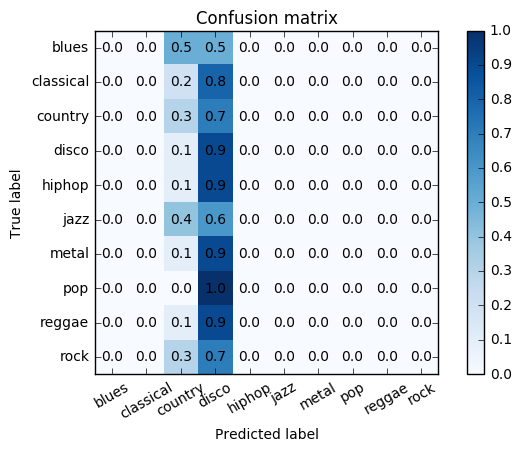

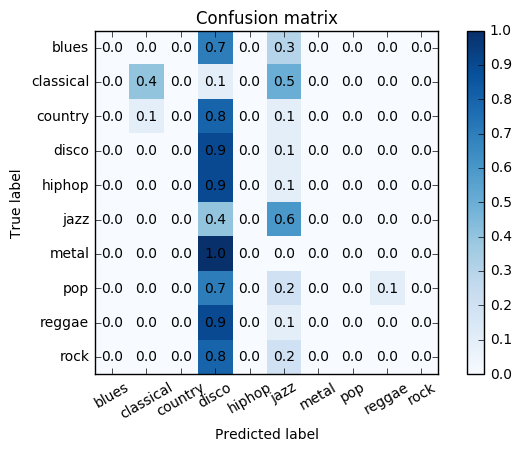

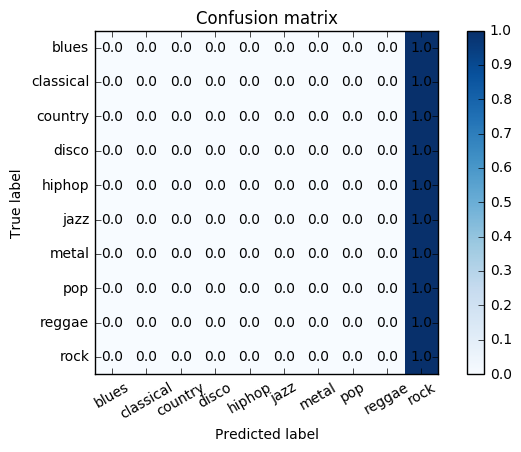

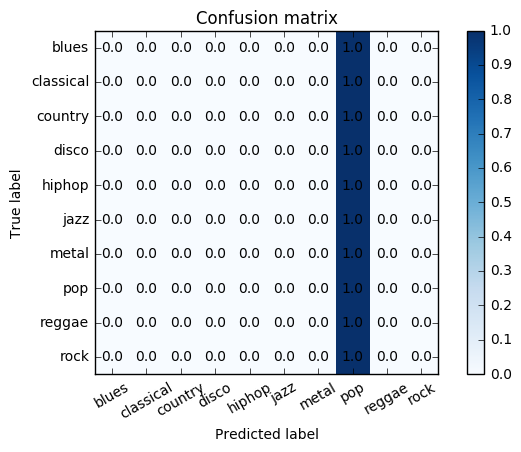

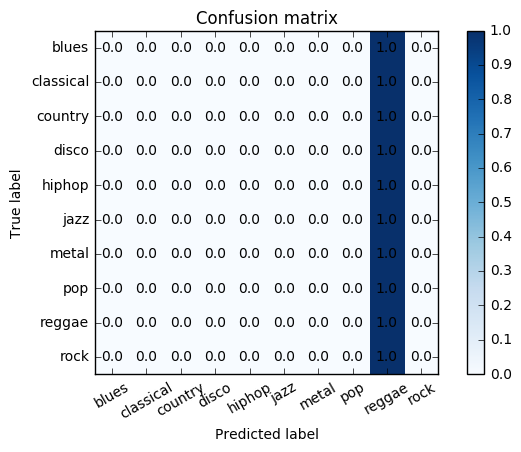

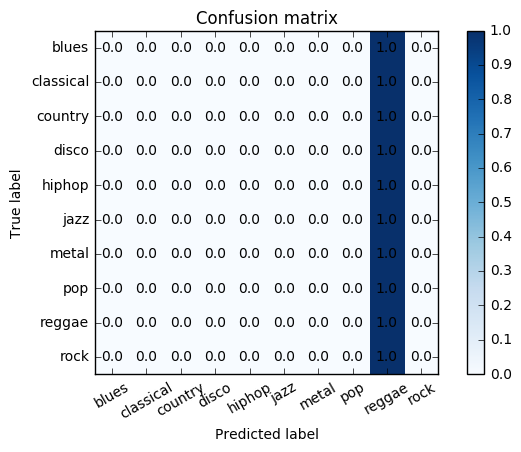

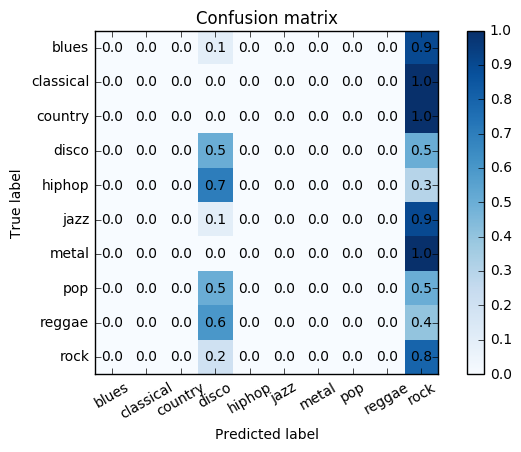

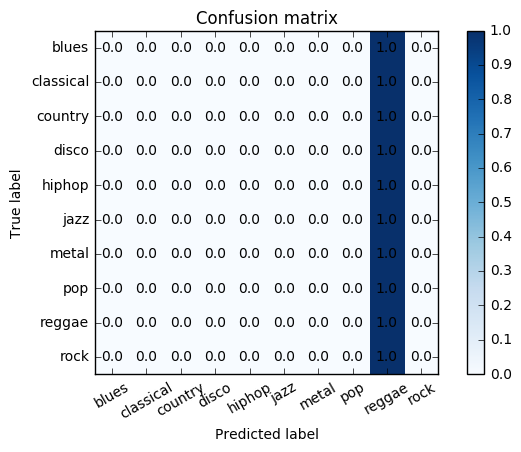

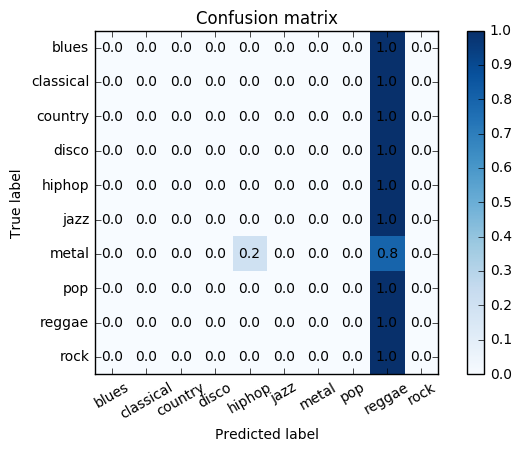

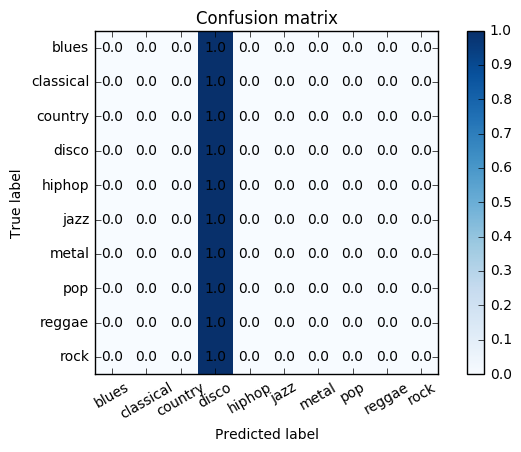

In [1]:
# train_0-9,test_0-9, train last output layer, save acc, loss, confusion matrix

import numpy as np
import h5py
import tensorflow as tf


train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 20
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
conf_marix = np.zeros([10,epochs,10,10])
    
from mlxtend.evaluate import confusion_matrix    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

W_h = weight_variable([32,100])
b_h = bias_variable([100])
W = weight_variable([100,10])
b = bias_variable([10])
y_input = tf.placeholder('float',shape=[None,10])
y = np.zeros([1,50])

with tf.Session() as sess:
    # load meta graph
    saver = tf.train.import_meta_graph('C:/Users/zwang10/Documents/Save_2/Epoch-19.meta')
    # restore weights
    saver.restore(sess,'C:/Users/zwang10/Documents/Save_2/Epoch-19')
    
    # create placeholders
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    y_ = graph.get_tensor_by_name("y_:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    phase = graph.get_tensor_by_name("phase:0")
    
    #Access the op you want to run. freeze weights of previous layers
    rnn_outputs_trans = graph.get_tensor_by_name("rnn_outputs_trans:0")
    print('rnn_outputs_trans:',rnn_outputs_trans.shape)
    outputs_fix = tf.unstack(rnn_outputs_trans)[-1] 
    outputs_fix = tf.stop_gradient(outputs_fix)
    
    results = tf.add(tf.matmul(outputs_fix, W_h), b_h)    # shape = (32, 100)
    results = tf.add(tf.matmul(results, W), b)    # shape = (100, 10)
    print('results = ',results.shape)
    
    output_results = tf.nn.softmax(results)
    
    results_bn = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=results_bn))
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step_1 = tf.train.AdamOptimizer(1e-4,name = 'adam_preTrained').minimize(cross_entropy)
  
    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:/Users/zwang10/Research/GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:/Users/zwang10/Research/GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:
            sess.run(tf.global_variables_initializer())
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step_1.run(feed_dict={x:x_p,y_:y, y_input:y_p, phase:True,keep_prob: 1.0})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                
                target = np.argmax(test_y_t,1)
                predicted = np.argmax(test_y_p,1)
                cm = confusion_matrix(y_target=target,y_predicted=predicted,binary=False)
                conf_marix[j,Itr,:,:] = cm
                
                test_prediction = np.equal(target,predicted)
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('test accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc_classifier.npy', acc)
np.save('loss_classifier.npy', loss)
np.save('conf_marix_classifier.npy', conf_marix)


import matplotlib.pyplot as plt

for j in range(10):
    cm = conf_marix[j,epochs-1,:,:]
    norm_conf_mat=cm/np.sum(cm,axis = 1)
    norm_conf_mat_round = np.around(norm_conf_mat,2)

    plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
    for x in range(10):
        for y in range(10):
            plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
    plt.colorbar()
    plt.tight_layout()
    alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    plt.xticks(range(len(alphabet)), alphabet, rotation=30 )
    plt.yticks(range(len(alphabet)), alphabet) 
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


h_conv1 =  (?, 1366, 96, 64)
h_pool1 =  (?, 683, 48, 64)
h_conv2 =  (?, 683, 48, 128)
h_pool2 =  (?, 228, 16, 128)
h_conv3 =  (?, 228, 16, 128)
h_pool3 =  (?, 57, 4, 128)
h_conv4 =  (?, 57, 4, 128)
h_pool4 =  (?, 15, 1, 128)
X_in =  (?, 15, 128)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.27
training loss: 1.984628713130951
training accuracy: 0.22
test loss: 2.0207391381263733

Epoch = 2
training accuracy: 0.41222224
training loss: 1.7999786992867788
training accuracy: 0.36
test loss: 1.8650638461112976

Epoch = 3
training accuracy: 0.46333334
training loss: 1.696992822488149
training accuracy: 0.49
test loss: 1.780008316040039

Epoch = 4
training accuracy: 0.5611111
training loss: 1.6136660436789194
training accuracy: 0.49
test loss: 1.7005249857902527

Epoch = 5
t

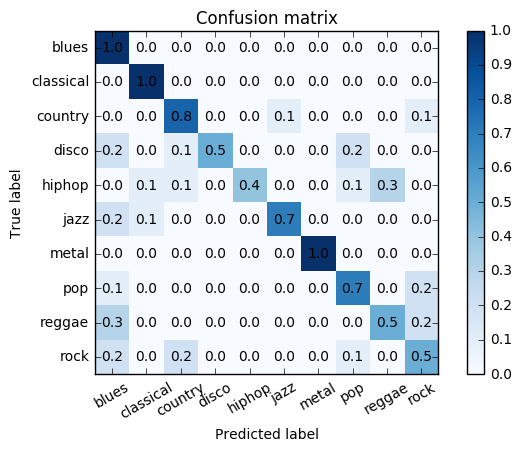

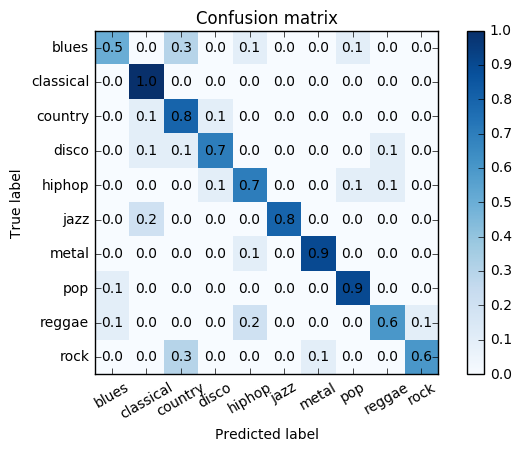

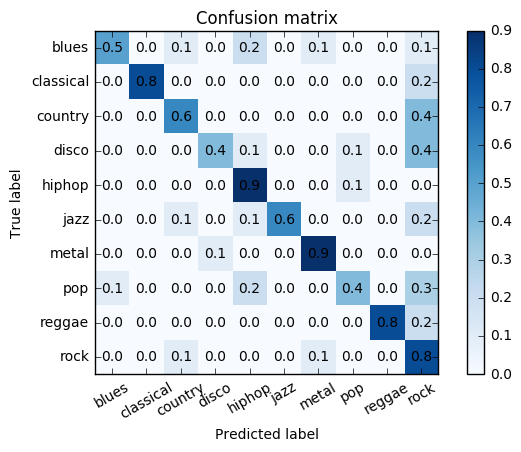

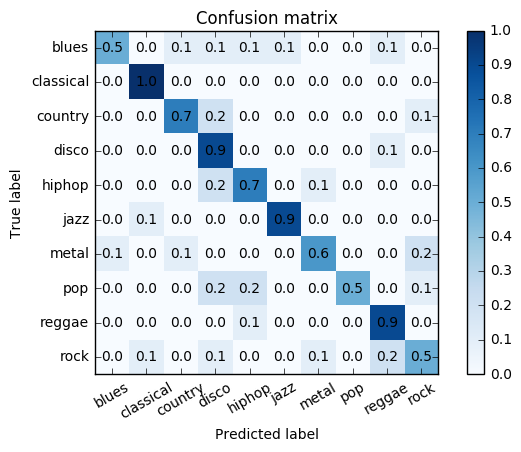

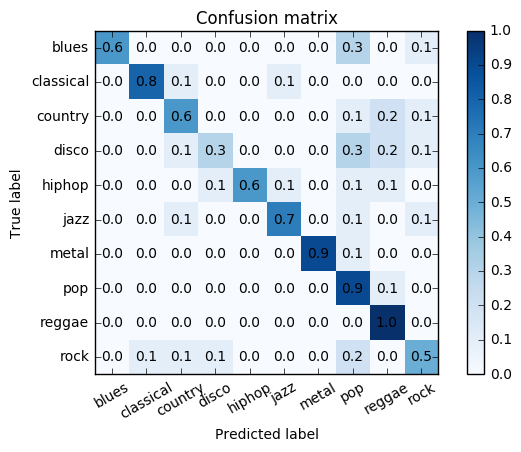

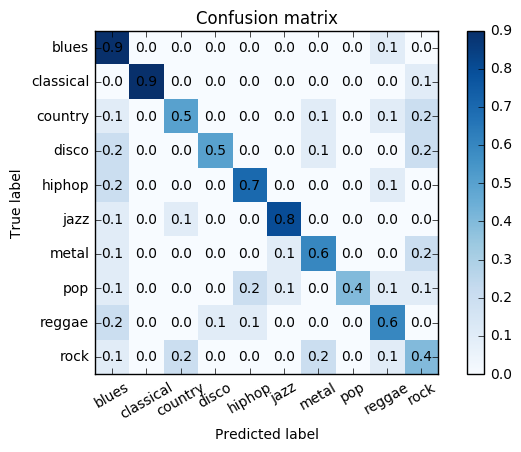

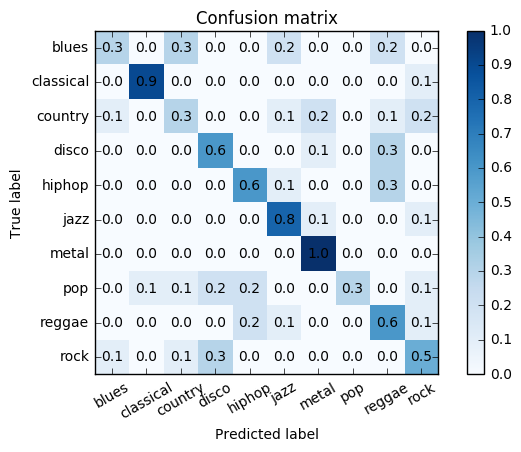

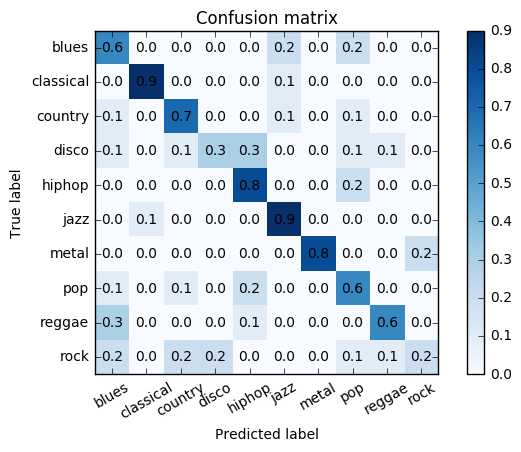

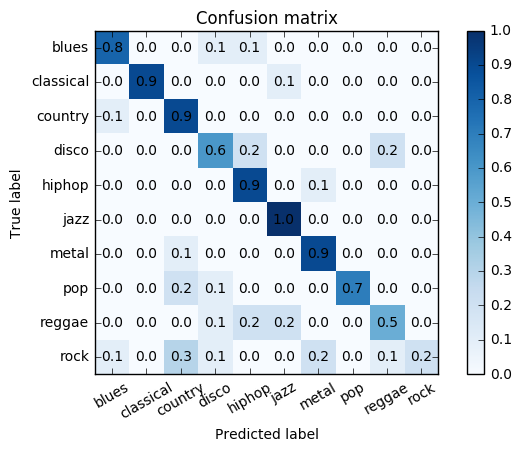

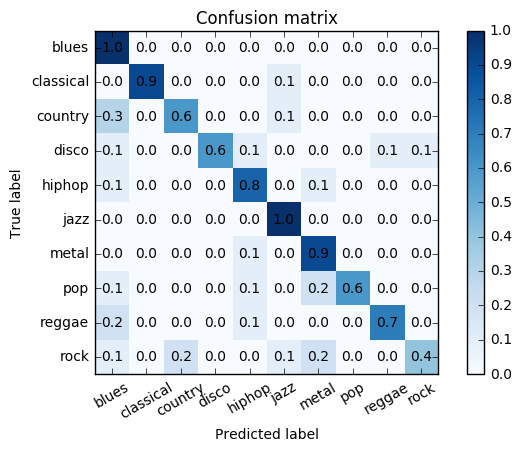

In [1]:
# train_0-9,test_0-9, random initilization, save acc, loss, confusion matrix

import numpy as np
import h5py
from sklearn import metrics
import tensorflow as tf


x = tf.placeholder(dtype='float',shape=[None,131136])
y_ = tf.placeholder('float',shape=[None,10])
keep_prob = tf.placeholder(dtype=tf.float32) 
phase = tf.placeholder(tf.bool) 

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
x_image = tf.reshape(x,[-1,1366,96,1])

W_conv1 = weight_variable([3,3,1,64])
b_conv1 = bias_variable([64])
conv1 = tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME') + b_conv1
conv1_bn = tf.contrib.layers.batch_norm(conv1,decay = 0.9,is_training=phase,scale=True)
h_conv1 = tf.nn.relu(conv1_bn)
print('h_conv1 = ',h_conv1.shape)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print('h_pool1 = ',h_pool1.shape)

W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])
conv2 = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME') + b_conv2
conv2_bn = tf.contrib.layers.batch_norm(conv2,decay = 0.9,is_training=phase,scale=True)
h_conv2 = tf.nn.relu(conv2_bn)
print('h_conv2 = ',h_conv2.shape)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,3,3,1],padding='SAME')
print('h_pool2 = ',h_pool2.shape)

W_conv3 = weight_variable([3,3,128,128])
b_conv3 = bias_variable([128])
conv3 = tf.nn.conv2d(h_pool2,W_conv3,strides=[1,1,1,1],padding='SAME') + b_conv3
conv3_bn = tf.contrib.layers.batch_norm(conv3,decay = 0.9,is_training=phase,scale=True)
h_conv3 = tf.nn.relu(conv3_bn)
print('h_conv3 = ',h_conv3.shape)
h_pool3 = tf.nn.max_pool(h_conv3,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool3 = ',h_pool3.shape)

W_conv4 = weight_variable([3,3,128,128])
b_conv4 = bias_variable([128])
conv4 = tf.nn.conv2d(h_pool3,W_conv4,strides=[1,1,1,1],padding='SAME') + b_conv4
conv4_bn = tf.contrib.layers.batch_norm(conv4,decay = 0.9, is_training=phase,scale=True)
h_conv4 = tf.nn.relu(conv4_bn)
print('h_conv4 = ',h_conv4.shape)
h_pool4 = tf.nn.max_pool(h_conv4,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
print('h_pool4 = ',h_pool4.shape)

shape_dimension = h_pool4.get_shape().as_list()
n_inputs = shape_dimension[2]*shape_dimension[3]
max_time = shape_dimension[1]
gru_size = 32
weights_out = weight_variable([gru_size,10])
biases_out = bias_variable([10])
X_in = tf.reshape(h_pool4, [-1, max_time, n_inputs]) 
print('X_in = ',X_in.shape)
multicell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(gru_size) for _ in range(2)])
cell = tf.contrib.rnn.DropoutWrapper(multicell,output_keep_prob = keep_prob) 
outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, dtype=tf.float32)
outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
results = tf.matmul(outputs[-1], weights_out) + biases_out  
results = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
print('results = ',results.shape)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=results))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
output_results = tf.nn.softmax(results)
init = tf.global_variables_initializer()

train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 50
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
conf_marix = np.zeros([10,epochs,10,10])   

from mlxtend.evaluate import confusion_matrix    
    
with tf.Session() as sess:
    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:\\Users\\zwang10\\Research\\GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:
            sess.run(init)
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step.run(feed_dict={x:x_p, y_:y_p, phase:True,keep_prob: 0.5})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p, y_:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p, y_: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                
                target = np.argmax(test_y_t,1)
                predicted = np.argmax(test_y_p,1)
                cm = confusion_matrix(y_target=target,y_predicted=predicted,binary=False)
                conf_marix[j,Itr,:,:] = cm
                
                test_prediction = np.equal(target,predicted)
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('test accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc_random.npy', acc)
np.save('loss_random.npy', loss)
np.save('conf_marix_random.npy', conf_marix)


import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix

for j in range(10):
    cm = conf_marix[j,epochs-1,:,:]
    norm_conf_mat=cm/np.sum(cm,axis = 1)
    norm_conf_mat_round = np.around(norm_conf_mat,2)

# method 1
#     fig, ax = plot_confusion_matrix(norm_conf_mat_round,figsize=(5.0,5.0))
#     plt.show()

    # method 2
    plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
    for x in range(10):
        for y in range(10):
            plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
    plt.colorbar()
    plt.tight_layout()
    alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    plt.xticks(range(len(alphabet)), alphabet, rotation=30 )
    plt.yticks(range(len(alphabet)), alphabet) 
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from C:/Users/zwang10/Documents/Save_2/Epoch-19
rnn_outputs_trans: (15, ?, 32)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.26555556
training loss: 2.0308557470639546
test accuracy: 0.2
test loss: 2.0517754793167113

Epoch = 2
training accuracy: 0.3422222
training loss: 1.775874517361323
test accuracy: 0.35
test loss: 1.81573383808136

Epoch = 3
training accuracy: 0.41
training loss: 1.6358843684196471
test accuracy: 0.38
test loss: 1.6889527082443236

Epoch = 4
training accuracy: 0.5177778
training loss: 1.50705948472023
test accuracy: 0.48
test loss: 1.5652552843093872

Epoch = 5
training accuracy: 0.58666664
training loss: 1.4275339802106222
test accuracy: 0.56
test loss: 1.4871553659439087

Epoch = 6
training accuracy: 0.65555

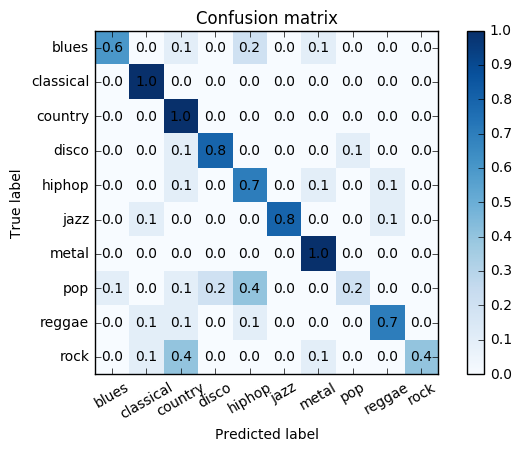

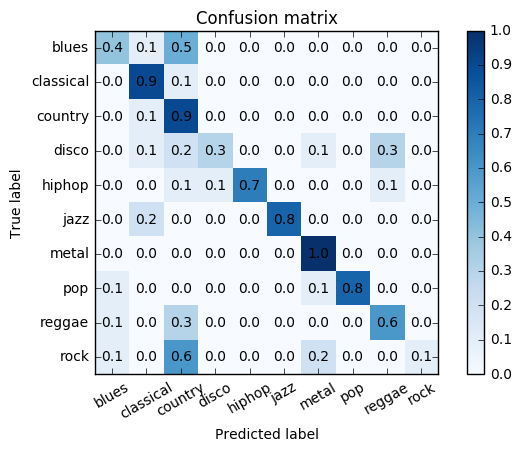

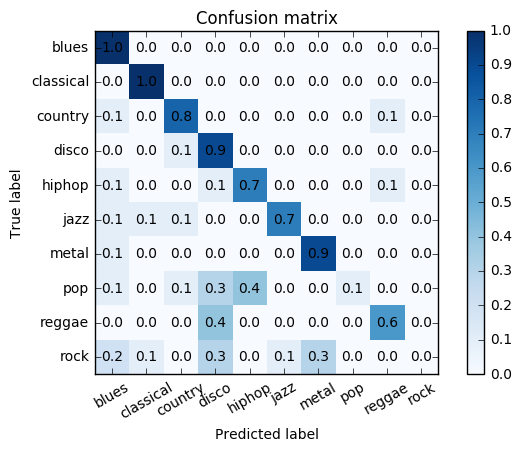

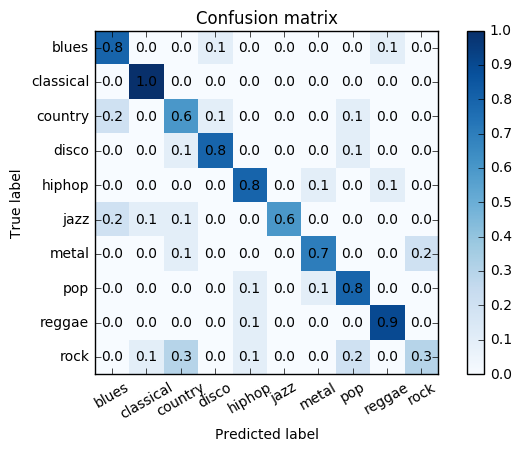

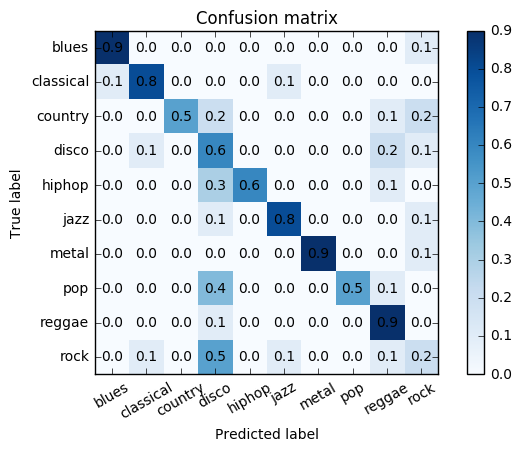

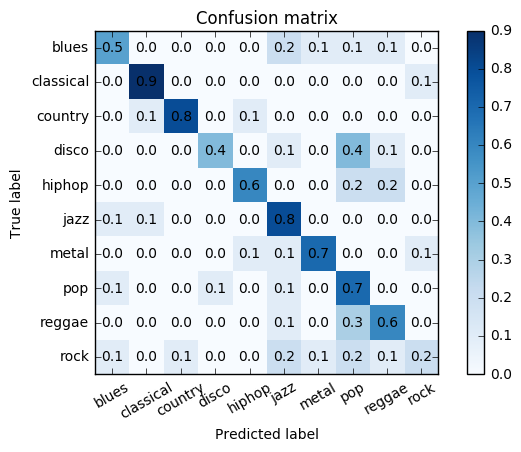

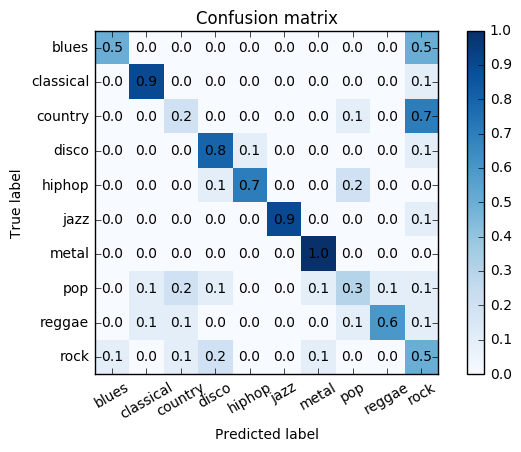

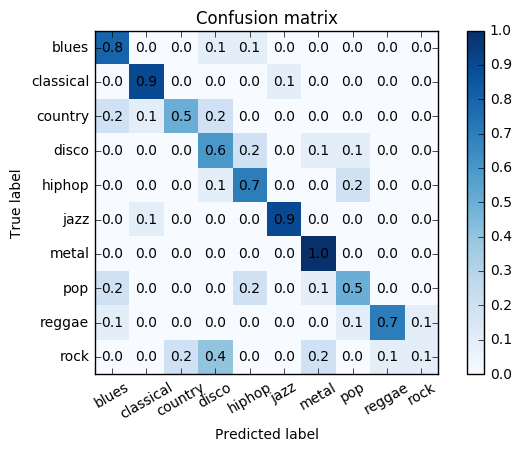

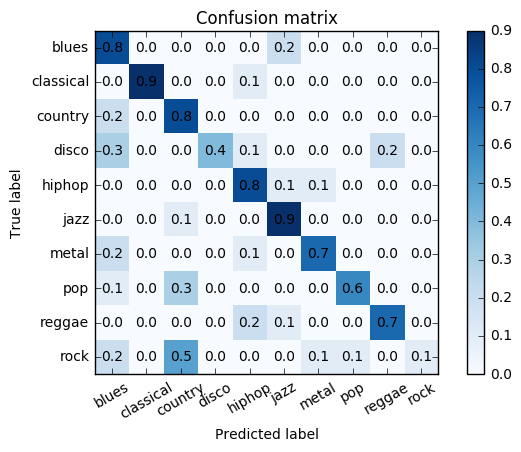

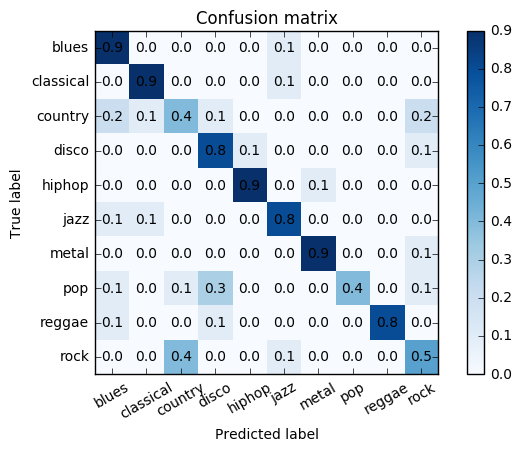

In [1]:
# train_0-9,test_0-9, train on pre-trained model(fine-tune RNN), save acc, loss, confusion matrix

import numpy as np
import h5py
import tensorflow as tf


train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 20
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
conf_marix = np.zeros([10,epochs,10,10])
    
from mlxtend.evaluate import confusion_matrix    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

W = weight_variable([32,10])
b = bias_variable([10])
y_input = tf.placeholder('float',shape=[None,10])
y = np.zeros([1,50])

with tf.Session() as sess:
    # load meta graph
    saver = tf.train.import_meta_graph('C:/Users/zwang10/Documents/Save_2/Epoch-19.meta')
    # restore weights
    saver.restore(sess,'C:/Users/zwang10/Documents/Save_2/Epoch-19')
    
    # create placeholders
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    y_ = graph.get_tensor_by_name("y_:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    phase = graph.get_tensor_by_name("phase:0")
    
    #Access the op you want to run. freeze weights of previous layers
    cnn_output = graph.get_tensor_by_name("cnn_output:0")
    cnn_output = tf.stop_gradient(cnn_output)
    rnn_outputs_trans = graph.get_tensor_by_name("rnn_outputs_trans:0")
    print('rnn_outputs_trans:',rnn_outputs_trans.shape)
    outputs_fix = tf.unstack(rnn_outputs_trans)[-1] 
    results = tf.add(tf.matmul(outputs_fix, W), b)    # shape = (32, 100)
    print('results = ',results.shape)
    
    output_results = tf.nn.softmax(results)
    
    results_bn = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=results_bn))
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step_1 = tf.train.AdamOptimizer(1e-4,name = 'adam_preTrained').minimize(cross_entropy)
  
    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:/Users/zwang10/Research/GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:/Users/zwang10/Research/GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:
            sess.run(tf.global_variables_initializer())
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step_1.run(feed_dict={x:x_p,y_:y, y_input:y_p, phase:True,keep_prob: 0.5})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                
                target = np.argmax(test_y_t,1)
                predicted = np.argmax(test_y_p,1)
                cm = confusion_matrix(y_target=target,y_predicted=predicted,binary=False)
                conf_marix[j,Itr,:,:] = cm
                
                test_prediction = np.equal(target,predicted)
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('test accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc_preTrained(RNN).npy', acc)
np.save('loss_preTrained(RNN).npy', loss)
np.save('conf_marix_preTrained(RNN).npy', conf_marix)


import matplotlib.pyplot as plt

for j in range(10):
    cm = conf_marix[j,epochs-1,:,:]
    norm_conf_mat=cm/np.sum(cm,axis = 1)
    norm_conf_mat_round = np.around(norm_conf_mat,2)

    plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
    for x in range(10):
        for y in range(10):
            plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
    plt.colorbar()
    plt.tight_layout()
    alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    plt.xticks(range(len(alphabet)), alphabet, rotation=30 )
    plt.yticks(range(len(alphabet)), alphabet) 
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from C:/Users/zwang10/Documents/Save_2/Epoch-19
rnn_outputs_trans: (15, ?, 32)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.25777778
training loss: 2.0221549034118653
test accuracy: 0.29
test loss: 2.0419766426086428

Epoch = 2
training accuracy: 0.32555556
training loss: 1.8105138619740804
test accuracy: 0.32
test loss: 1.827839970588684

Epoch = 3
training accuracy: 0.35444444
training loss: 1.7032458504041037
test accuracy: 0.29
test loss: 1.7717496633529664

Epoch = 4
training accuracy: 0.4511111
training loss: 1.5785170714060466
test accuracy: 0.34
test loss: 1.642836904525757

Epoch = 5
training accuracy: 0.5044444
training loss: 1.482292075951894
test accuracy: 0.43
test loss: 1.578323245048523

Epoch = 6
training accuracy:

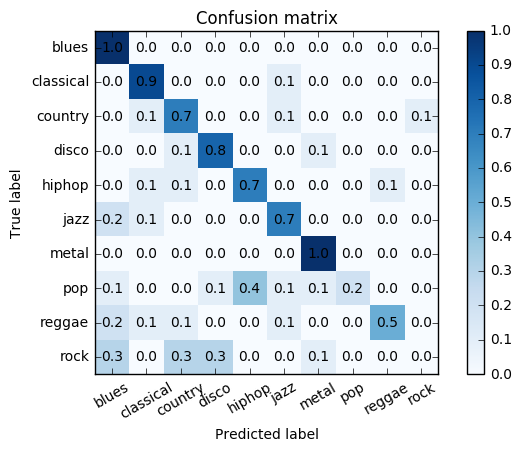

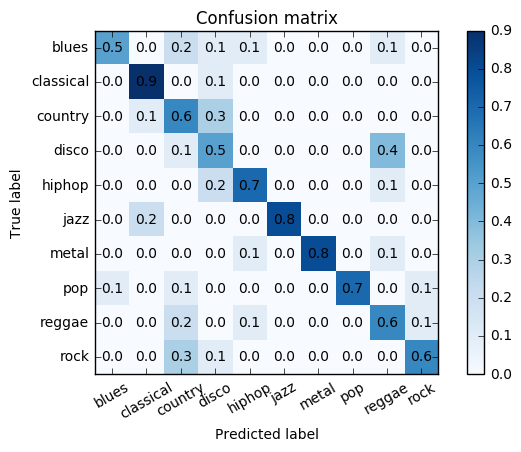

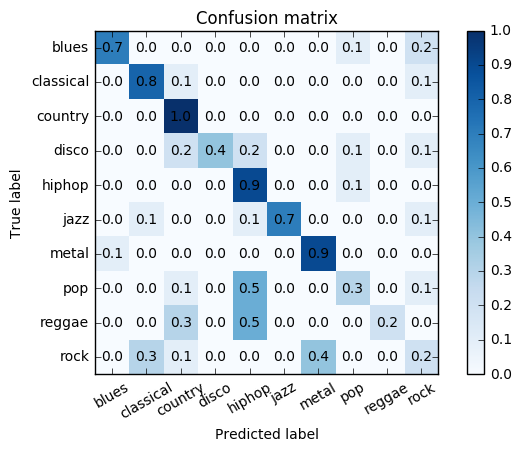

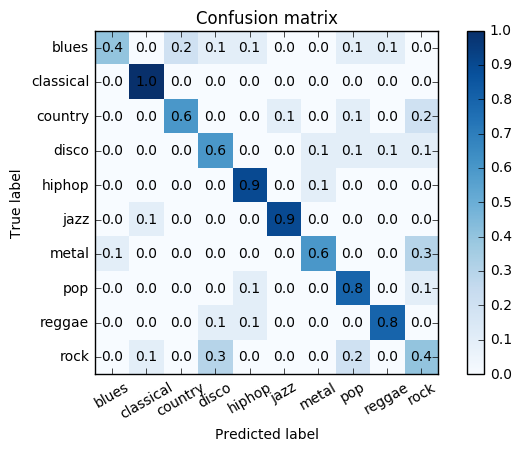

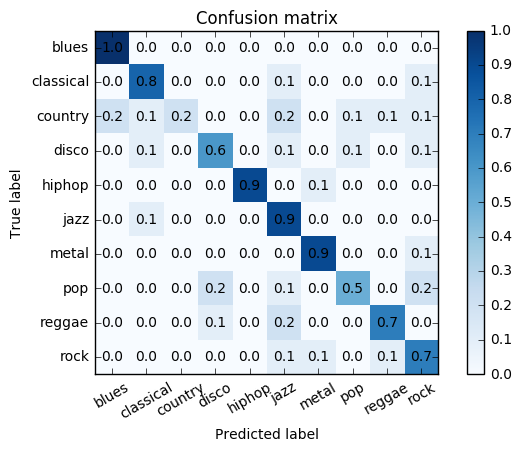

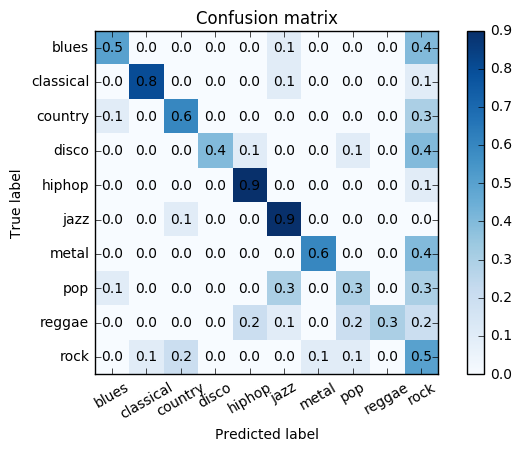

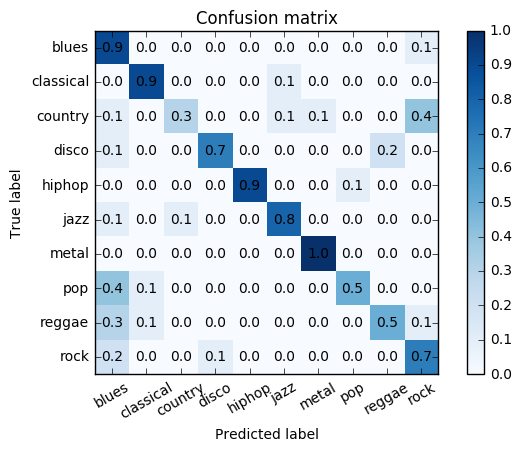

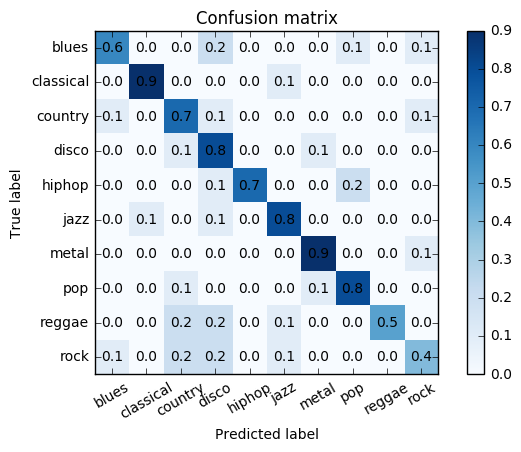

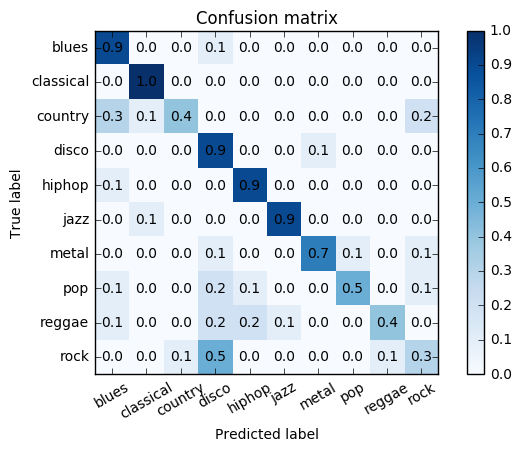

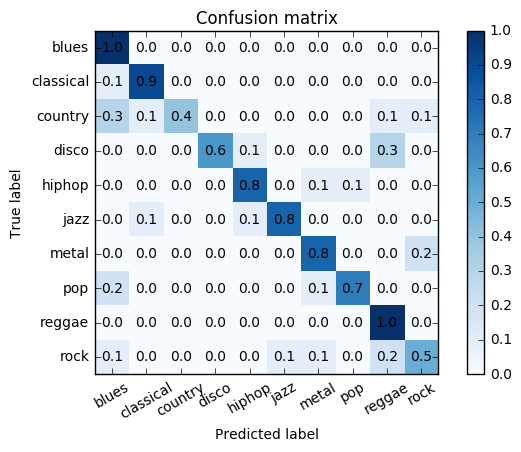

In [1]:
# train_0-9,test_0-9, train on pre-trained model( fine-tune last layer in CNN + RNN), save acc, loss, confusion matrix

import numpy as np
import h5py
import tensorflow as tf


train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 20
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
conf_marix = np.zeros([10,epochs,10,10])
    
from mlxtend.evaluate import confusion_matrix    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

W = weight_variable([32,10])
b = bias_variable([10])
y_input = tf.placeholder('float',shape=[None,10])
y = np.zeros([1,50])

with tf.Session() as sess:
    # load meta graph
    saver = tf.train.import_meta_graph('C:/Users/zwang10/Documents/Save_2/Epoch-19.meta')
    # restore weights
    saver.restore(sess,'C:/Users/zwang10/Documents/Save_2/Epoch-19')
    
    # create placeholders
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    y_ = graph.get_tensor_by_name("y_:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    phase = graph.get_tensor_by_name("phase:0")
    
    #Access the op you want to run. freeze weights of previous layers
    h_pool3 = graph.get_tensor_by_name("h_pool3:0")
    h_pool3 = tf.stop_gradient(h_pool3)
    rnn_outputs_trans = graph.get_tensor_by_name("rnn_outputs_trans:0")
    print('rnn_outputs_trans:',rnn_outputs_trans.shape)
    outputs_fix = tf.unstack(rnn_outputs_trans)[-1] 
    results = tf.add(tf.matmul(outputs_fix, W), b)    # shape = (32, 100)
    print('results = ',results.shape)
    
    output_results = tf.nn.softmax(results)
    
    results_bn = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=results_bn))
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step_1 = tf.train.AdamOptimizer(1e-4,name = 'adam_preTrained').minimize(cross_entropy)

    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:/Users/zwang10/Research/GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:/Users/zwang10/Research/GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:  
            sess.run(tf.global_variables_initializer())
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step_1.run(feed_dict={x:x_p,y_:y, y_input:y_p, phase:True,keep_prob: 0.5})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                
                target = np.argmax(test_y_t,1)
                predicted = np.argmax(test_y_p,1)
                cm = confusion_matrix(y_target=target,y_predicted=predicted,binary=False)
                conf_marix[j,Itr,:,:] = cm
                
                test_prediction = np.equal(target,predicted)
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('test accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc_preTrained(lastConv+RNN).npy', acc)
np.save('loss_preTrained(lastConv+RNN).npy', loss)
np.save('conf_marix_preTrained(lastConv+RNN).npy', conf_marix)


import matplotlib.pyplot as plt

for j in range(10):
    cm = conf_marix[j,epochs-1,:,:]
    norm_conf_mat=cm/np.sum(cm,axis = 1)
    norm_conf_mat_round = np.around(norm_conf_mat,2)

    plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
    for x in range(10):
        for y in range(10):
            plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
    plt.colorbar()
    plt.tight_layout()
    alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    plt.xticks(range(len(alphabet)), alphabet, rotation=30 )
    plt.yticks(range(len(alphabet)), alphabet) 
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

C:\Users\zwang10\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from C:/Users/zwang10/Documents/Save_2/Epoch-19
rnn_outputs_trans: (15, ?, 32)
results =  (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


K-fold validation,j = 0

Epoch = 1
training accuracy: 0.13
training loss: 2.0396464506785077
test accuracy: 0.13
test loss: 2.0395152091979982

Epoch = 2
training accuracy: 0.30333334
training loss: 1.820045671860377
test accuracy: 0.27
test loss: 1.8508961200714111

Epoch = 3
training accuracy: 0.37333333
training loss: 1.6682225346565247
test accuracy: 0.43
test loss: 1.7263144969940185

Epoch = 4
training accuracy: 0.49333334
training loss: 1.5937928179899852
test accuracy: 0.46
test loss: 1.6559996843338012

Epoch = 5
training accuracy: 0.5611111
training loss: 1.5175134321053823
test accuracy: 0.5
test loss: 1.596207070350647

Epoch = 6
training accuracy: 0.6

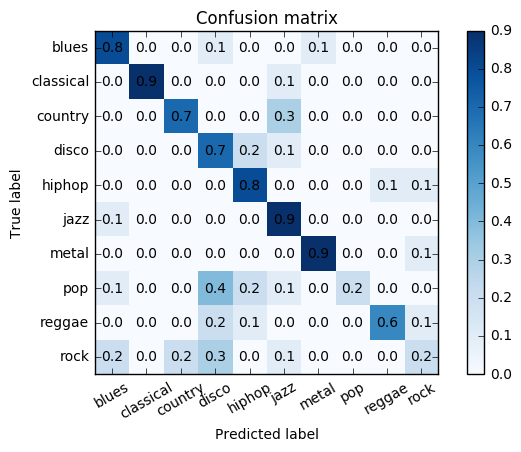

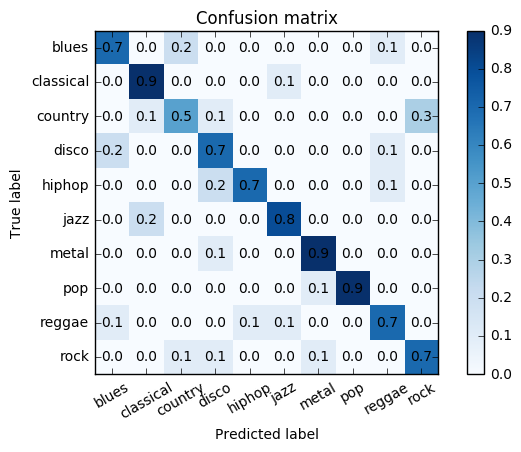

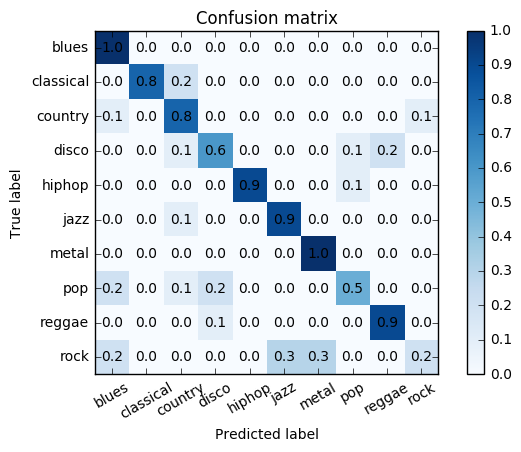

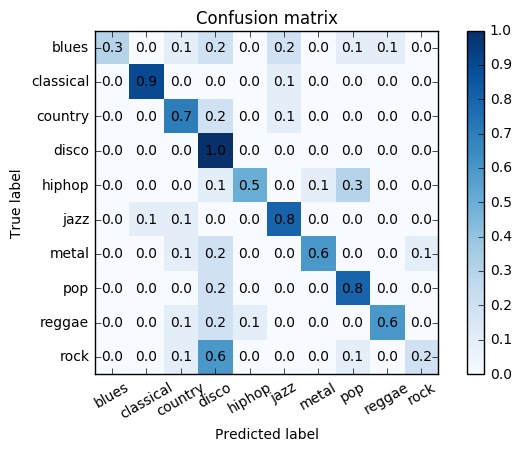

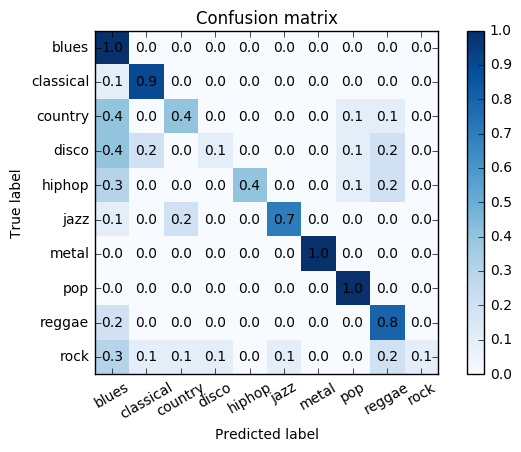

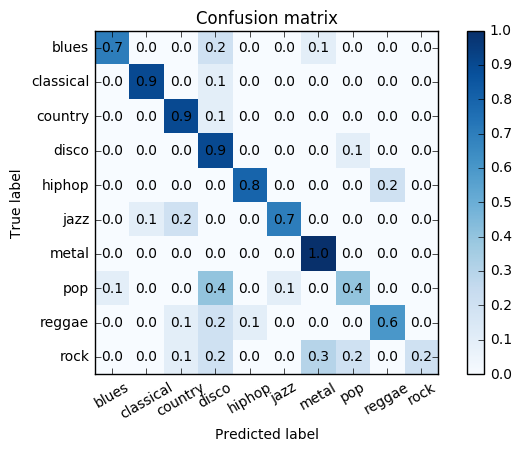

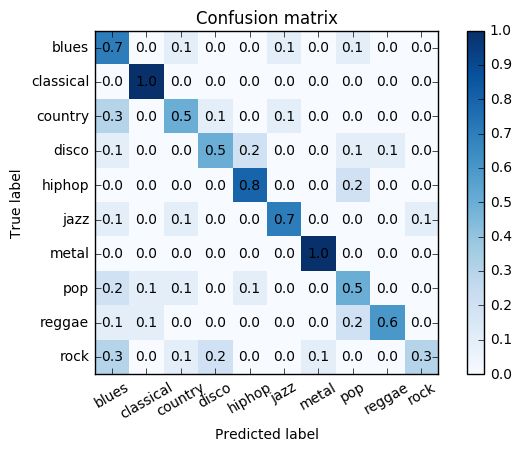

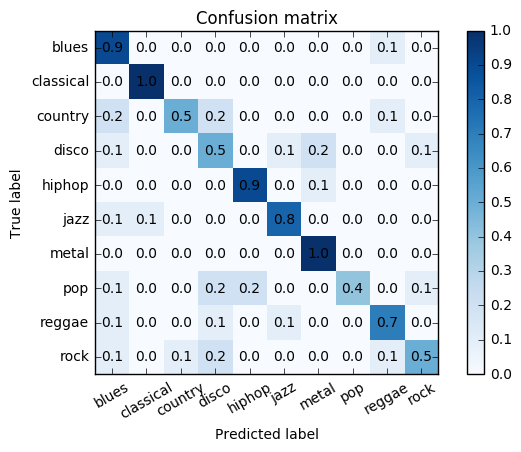

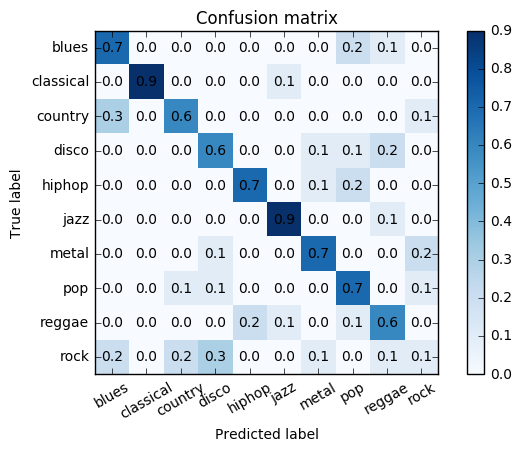

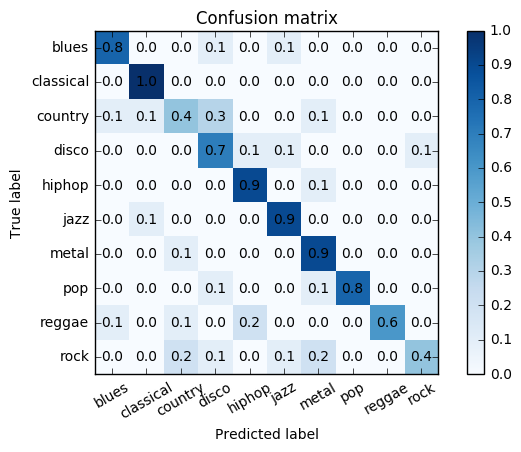

In [1]:
# train_0-9,test_0-9, train on pre-trained model(fine-tune CNN + RNN), save acc, loss, confusion matrix

import numpy as np
import h5py
import tensorflow as tf


train_y_t = np.zeros((900,10),dtype='int8')
train_y_p = np.zeros((900,10),dtype='float32')
test_y_t = np.zeros((100,10),dtype='int8')
test_y_p = np.zeros((100,10),dtype='float32')

train_batch_size = 30
train_steps = 900//train_batch_size
train_loss = np.zeros([train_steps,])
test_batch_size = 20
test_steps = 100//test_batch_size
test_loss = np.zeros([test_steps,])

arr_index = np.arange(900)
for i in range(10):
    np.random.shuffle(arr_index)

epochs = 50
acc = np.zeros([10,epochs,2]) 
loss = np.zeros([10,epochs,2])
conf_marix = np.zeros([10,epochs,10,10])
    
from mlxtend.evaluate import confusion_matrix    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# W_h = weight_variable([32,100])
# b_h = bias_variable([100])

W = weight_variable([32,10])
b = bias_variable([10])
y_input = tf.placeholder('float',shape=[None,10])
y = np.zeros([1,50])

with tf.Session() as sess:
    # load meta graph
    saver = tf.train.import_meta_graph('C:/Users/zwang10/Documents/Save_2/Epoch-19.meta')
    # restore weights
    saver.restore(sess,'C:/Users/zwang10/Documents/Save_2/Epoch-19')
    
    # create placeholders
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x:0")
    y_ = graph.get_tensor_by_name("y_:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    phase = graph.get_tensor_by_name("phase:0")
    
    #Access the op you want to run. freeze weights of previous layers
    rnn_outputs_trans = graph.get_tensor_by_name("rnn_outputs_trans:0")
    print('rnn_outputs_trans:',rnn_outputs_trans.shape)
    outputs_fix = tf.unstack(rnn_outputs_trans)[-1]
#     outputs_fix = tf.stop_gradient(outputs)
    
    # Add more ops
    
    
#     results = tf.add(tf.matmul(outputs_fix, W_h), b_h)    # shape = (32, 100)
#     print('results = ',results.shape)
#     results = tf.add(tf.matmul(results, W), b)    # shape = (32, 100)
#     print('results = ',results.shape)
    
    results = tf.add(tf.matmul(outputs_fix, W), b)    # shape = (32, 100)
    print('results = ',results.shape)
    
    output_results = tf.nn.softmax(results)
    
#     cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=results))
    results_bn = tf.contrib.layers.batch_norm(results,decay = 0.9,is_training=phase,scale=True)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=results_bn))
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step_1 = tf.train.AdamOptimizer(1e-4,name = 'adam_preTrained').minimize(cross_entropy)
#         train_step_1 = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    for j in range(10):
        print('\nK-fold validation,j =',j)
        with h5py.File('C:/Users/zwang10/Research/GTZANDataset_train_'+('%d' % j)+'.hdf5','r') as f_train, h5py.File('C:/Users/zwang10/Research/GTZANDataset_test_'+('%d' % j)+'.hdf5','r') as f_test:
            sess.run(tf.global_variables_initializer())
            for Itr in range(epochs):
                print('\nEpoch = %d' % (Itr+1))   
                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][np.sort(arr_index[start:end]),:]
                    y_p = f_train['Data']['tags'][np.sort(arr_index[start:end]),:]
                    train_step_1.run(feed_dict={x:x_p,y_:y, y_input:y_p, phase:True,keep_prob: 0.5})

                for i in range(train_steps):
                    start = i*train_batch_size
                    end = (i+1)*train_batch_size
                    x_p = f_train['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_train['Data']['tags'][start:end,:]
                    train_y_t[start:end,:] = y_p
                    train_y_p[start:end,:] = sess.run(output_results,feed_dict={
                            x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    train_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                for i in range(test_steps):
                    start = i*test_batch_size
                    end = (i+1)*test_batch_size
                    x_p = f_test['Data']['melSpectrogram_ColMajor'][start:end,:]
                    y_p = f_test['Data']['tags'][start:end,:]
                    test_y_t[start:end,:] = y_p
                    test_y_p[start:end,:] = sess.run(output_results,feed_dict={
                        x:x_p,y_:y, y_input:y_p, phase:False,keep_prob: 1.0})
                    test_loss[i] = sess.run(cross_entropy,feed_dict={x: x_p,y_:y, y_input: y_p,phase:False, keep_prob: 1.0})
                    
                train_prediction = np.equal(np.argmax(train_y_t,1), np.argmax(train_y_p,1))
                train_acc = np.mean(train_prediction.astype(np.float32))
                print('training accuracy:',train_acc)
                print('training loss:',np.mean(train_loss))
                
                target = np.argmax(test_y_t,1)
                predicted = np.argmax(test_y_p,1)
                cm = confusion_matrix(y_target=target,y_predicted=predicted,binary=False)
                conf_marix[j,Itr,:,:] = cm
                
                test_prediction = np.equal(target,predicted)
                test_acc = np.mean(test_prediction.astype(np.float32))
                print('test accuracy:',test_acc)
                print('test loss:',np.mean(test_loss))
                acc[j,Itr,0] = train_acc
                acc[j,Itr,1] = test_acc
                loss[j,Itr,0] = np.mean(train_loss)
                loss[j,Itr,1] = np.mean(test_loss)
np.save('acc_preTrained(CRNN).npy', acc)
np.save('loss_preTrained(CRNN).npy', loss)
np.save('conf_marix_preTrained(CRNN).npy', conf_marix)

import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix

for j in range(10):
    cm = conf_marix[j,epochs-1,:,:]
    norm_conf_mat=cm/np.sum(cm,axis = 1)
    norm_conf_mat_round = np.around(norm_conf_mat,2)

# method 1
#     fig, ax = plot_confusion_matrix(norm_conf_mat_round,figsize=(5.0,5.0))
#     plt.show()

    # method 2
    plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
    for x in range(10):
        for y in range(10):
            plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
    plt.colorbar()
    plt.tight_layout()
    alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    plt.xticks(range(len(alphabet)), alphabet, rotation=30 )
    plt.yticks(range(len(alphabet)), alphabet) 
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

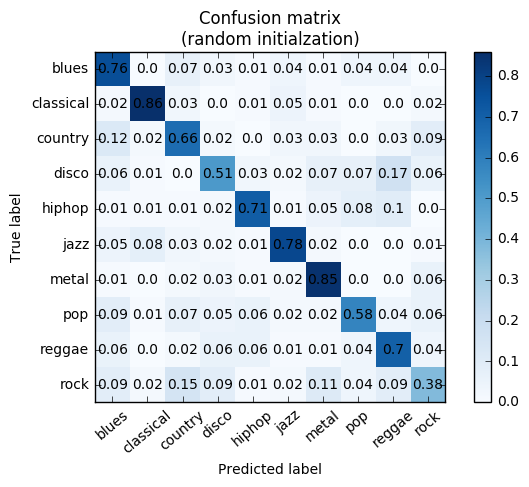

In [1]:
import numpy as np
import matplotlib.pyplot as plt

conf_marix_1 = np.load('./Performance/conf_marix_random.npy')
# print(conf_marix_1[:,22,:,:].shape)
conf_marix_1 = np.mean(conf_marix_1[:,22,:,:],axis = 0)
# print(conf_marix_1.shape)

cm = conf_marix_1
norm_conf_mat=cm/np.sum(cm,axis = 1)
norm_conf_mat_round = np.around(norm_conf_mat,4)

plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
for x in range(10):
    for y in range(10):
        plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
plt.colorbar()
plt.tight_layout()
alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
plt.xticks(range(len(alphabet)), alphabet, rotation=40 )
plt.yticks(range(len(alphabet)), alphabet) 
plt.title('Confusion matrix\n(random initialzation)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

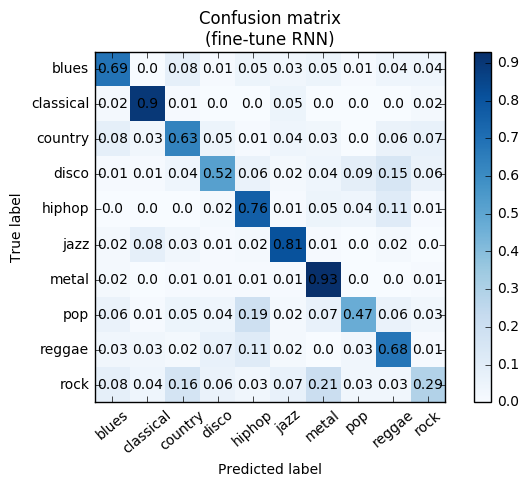

In [1]:
import numpy as np
import matplotlib.pyplot as plt

conf_marix_2 = np.load('./Performance/conf_marix_preTrained(RNN).npy')
conf_marix_2 = np.mean(conf_marix_2[:,22,:,:],axis = 0)

cm = conf_marix_2
norm_conf_mat=cm/np.sum(cm,axis = 1)
norm_conf_mat_round = np.around(norm_conf_mat,4)

plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
for x in range(10):
    for y in range(10):
        plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
plt.colorbar()
plt.tight_layout()
alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
plt.xticks(range(len(alphabet)), alphabet, rotation=40 )
plt.yticks(range(len(alphabet)), alphabet) 
plt.title('Confusion matrix\n(fine-tune RNN)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

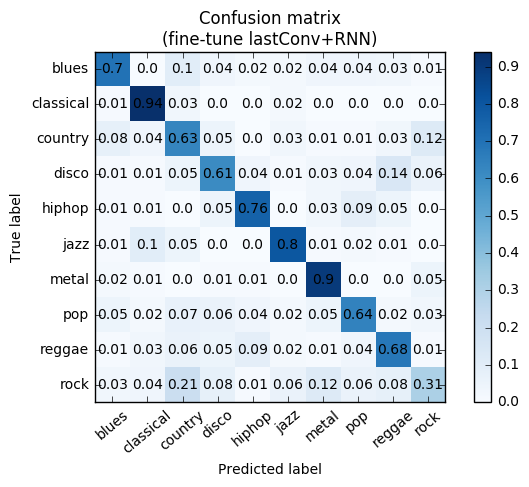

In [1]:
import numpy as np
import matplotlib.pyplot as plt

conf_marix_3 = np.load('./Performance/conf_marix_preTrained(lastConv+RNN).npy')
conf_marix_3 = np.mean(conf_marix_3[:,22,:,:],axis = 0)

cm = conf_marix_3
norm_conf_mat=cm/np.sum(cm,axis = 1)
norm_conf_mat_round = np.around(norm_conf_mat,4)

plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
for x in range(10):
    for y in range(10):
        plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
plt.colorbar()
plt.tight_layout()
alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
plt.xticks(range(len(alphabet)), alphabet, rotation=40 )
plt.yticks(range(len(alphabet)), alphabet) 
plt.title('Confusion matrix\n(fine-tune lastConv+RNN)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# conf_marix_4 = np.load('./Performance/conf_marix_preTrained(CRNN).npy')
# conf_marix_4 = np.mean(conf_marix_4[:,22,:,:],axis = 0)

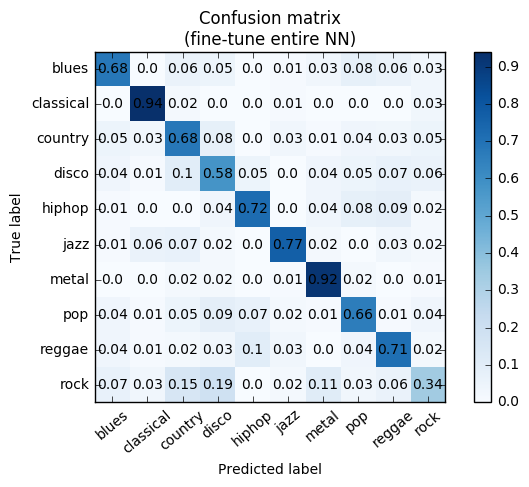

In [1]:
import numpy as np
import matplotlib.pyplot as plt

conf_marix_4 = np.load('./Performance/conf_marix_preTrained(CRNN).npy')
conf_marix_4 = np.mean(conf_marix_4[:,22,:,:],axis = 0)

cm = conf_marix_4
norm_conf_mat=cm/np.sum(cm,axis = 1)
norm_conf_mat_round = np.around(norm_conf_mat,4)

plt.imshow(norm_conf_mat_round,cmap=plt.cm.Blues, interpolation='nearest')
for x in range(10):
    for y in range(10):
        plt.annotate(norm_conf_mat_round[x][y], xy=(y, x), horizontalalignment='center',verticalalignment='center') 
plt.colorbar()
plt.tight_layout()
alphabet = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
plt.xticks(range(len(alphabet)), alphabet, rotation=40 )
plt.yticks(range(len(alphabet)), alphabet) 
plt.title('Confusion matrix\n(fine-tune entire NN)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()